In [5]:
import os
import onnx
import torch
import numpy as np
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader, Dataset
from brevitas.nn import QuantLinear, QuantReLU
import torch.nn as nn
from sklearn.metrics import accuracy_score
from tqdm import tqdm, trange

## Get data

! wget -O unsw_nb15_binarized.npz https://zenodo.org/record/4519767/files/unsw_nb15_binarized.npz?download=1

def get_preqnt_dataset(data_dir: str, train: bool):
    unsw_nb15_data = np.load(data_dir + "/unsw_nb15_binarized.npz")
    if train:
        partition = "train"
    else:
        partition = "test"
    part_data = unsw_nb15_data[partition].astype(np.float32)
    part_data = torch.from_numpy(part_data)
    part_data_in = part_data[:, :-1]
    part_data_out = part_data[:, -1]
    return TensorDataset(part_data_in, part_data_out)

train_quantized_dataset = get_preqnt_dataset(".", True)
test_quantized_dataset = get_preqnt_dataset(".", False)

print("Samples in each set: train = %d, test = %s" % (len(train_quantized_dataset), len(test_quantized_dataset))) 
print("Shape of one input sample: " +  str(train_quantized_dataset[0][0].shape))

batch_size = 1000

# dataset loaders
train_quantized_loader = DataLoader(train_quantized_dataset, batch_size=batch_size, shuffle=True)
test_quantized_loader = DataLoader(test_quantized_dataset, batch_size=batch_size, shuffle=False)    

count = 0
for x,y in train_quantized_loader:
    print("Input shape for 1 batch: " + str(x.shape))
    print("Label shape for 1 batch: " + str(y.shape))
    count += 1
    if count == 1:
        break

--2024-08-13 14:59:15--  https://zenodo.org/record/4519767/files/unsw_nb15_binarized.npz?download=1
Resolving zenodo.org (zenodo.org)... 188.184.98.238, 188.184.103.159, 188.185.79.172, ...
Connecting to zenodo.org (zenodo.org)|188.184.98.238|:443... connected.
HTTP request sent, awaiting response... 301 MOVED PERMANENTLY
Location: /records/4519767/files/unsw_nb15_binarized.npz [following]
--2024-08-13 14:59:15--  https://zenodo.org/records/4519767/files/unsw_nb15_binarized.npz
Reusing existing connection to zenodo.org:443.
HTTP request sent, awaiting response... 200 OK
Length: 13391907 (13M) [application/octet-stream]
Saving to: ‘unsw_nb15_binarized.npz’

unsw_nb15_binarized 100%[===================>]  12.77M  20.6MB/s    in 0.6s    

2024-08-13 14:59:16 (20.6 MB/s) - ‘unsw_nb15_binarized.npz’ saved [13391907/13391907]

Samples in each set: train = 175341, test = 82332
Shape of one input sample: torch.Size([593])
Input shape for 1 batch: torch.Size([1000, 593])
Label shape for 1 batch

In [7]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Target device: " + str(device))

input_size = 593      
hidden1 = 64      
hidden2 = 64
hidden3 = 64
weight_bit_width = 2
act_bit_width = 2
num_classes = 1   

# Setting seeds for reproducibility
torch.manual_seed(0)

model = nn.Sequential(
      QuantLinear(input_size, hidden1, bias=True, weight_bit_width=weight_bit_width),
      nn.BatchNorm1d(hidden1),
      nn.Dropout(0.5),
      QuantReLU(bit_width=act_bit_width),
      QuantLinear(hidden1, hidden2, bias=True, weight_bit_width=weight_bit_width),
      nn.BatchNorm1d(hidden2),
      nn.Dropout(0.5),
      QuantReLU(bit_width=act_bit_width),
      QuantLinear(hidden2, hidden3, bias=True, weight_bit_width=weight_bit_width),
      nn.BatchNorm1d(hidden3),
      nn.Dropout(0.5),
      QuantReLU(bit_width=act_bit_width),
      QuantLinear(hidden3, num_classes, bias=True, weight_bit_width=weight_bit_width)
)

model.to(device); # The semicolon is for not printing the model.

def train(model, train_loader, optimizer, criterion):
    losses = []
    # ensure model is in training mode
    model.train()    
    
    for i, data in enumerate(train_loader, 0):
        # print('data', data)
        inputs, target = data
        inputs, target = inputs.to(device), target.to(device)
        optimizer.zero_grad()   
                
        # forward pass
        output = model(inputs.float())
        loss = criterion(output, target.unsqueeze(1))
        
        # backward pass + run optimizer to update weights
        loss.backward()
        optimizer.step()
        
        # keep track of loss value
        losses.append(loss.data.cpu().numpy()) 
           
    return losses


def test(model, test_loader):    
    # ensure model is in eval mode
    model.eval() 
    y_true = []
    y_pred = []
   
    with torch.no_grad():
        for data in test_loader:
            inputs, target = data
            inputs, target = inputs.to(device), target.to(device)
            output_orig = model(inputs.float())
            # run the output through sigmoid
            output = torch.sigmoid(output_orig)  
            # compare against a threshold of 0.5 to generate 0/1
            pred = (output.detach().cpu().numpy() > 0.5) * 1
            target = target.cpu().float()
            y_true.extend(target.tolist()) 
            y_pred.extend(pred.reshape(-1).tolist())
        
    return accuracy_score(y_true, y_pred)

num_epochs = 10
lr = 0.001 

def display_loss_plot(losses, title="Training loss", xlabel="Iterations", ylabel="Loss"):
    x_axis = [i for i in range(len(losses))]
    plt.plot(x_axis,losses)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()

# loss criterion and optimizer
criterion = nn.BCEWithLogitsLoss().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr, betas=(0.9, 0.999))

# Setting seeds for reproducibility
torch.manual_seed(0)
np.random.seed(0)

running_loss = []
running_test_acc = []
t = trange(num_epochs, desc="Training loss", leave=True)

for epoch in t:
        loss_epoch = train(model, train_quantized_loader, optimizer,criterion)
        test_acc = test(model, test_quantized_loader)
        t.set_description("Training loss = %f test accuracy = %f" % (np.mean(loss_epoch), test_acc))
        t.refresh() # to show immediately the update           
        running_loss.append(loss_epoch)
        running_test_acc.append(test_acc)



Target device: cpu


Training loss:   0%|                                                              | 0/10 [07:09<?, ?it/s]


KeyboardInterrupt: 

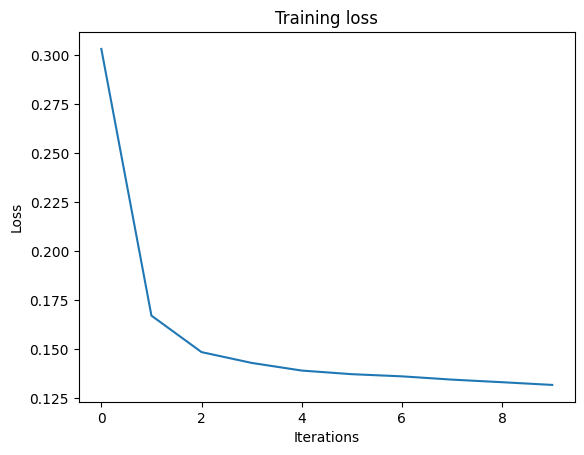

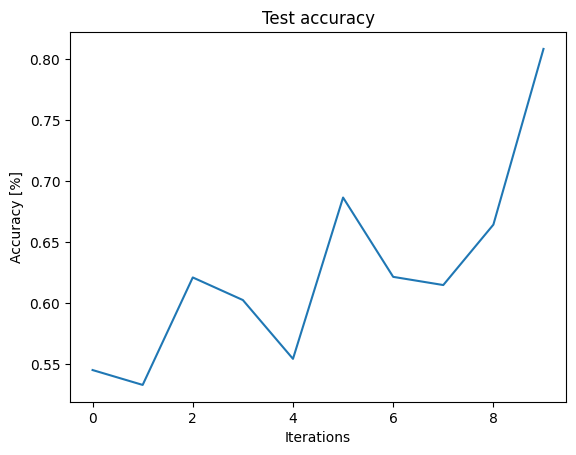

0.8083491230627217

In [22]:
%matplotlib inline
import matplotlib.pyplot as plt

loss_per_epoch = [np.mean(loss_per_epoch) for loss_per_epoch in running_loss]
display_loss_plot(loss_per_epoch)

acc_per_epoch = [np.mean(acc_per_epoch) for acc_per_epoch in running_test_acc]
display_loss_plot(acc_per_epoch, title="Test accuracy", ylabel="Accuracy [%]")

test(model, test_quantized_loader)

In [23]:
torch.save(model.state_dict(), "state_dict_self-trained.pth")